In [33]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sn
import torch

# Importando dados

In [34]:
treino = torch.load("../data/treino.pt")
teste = torch.load("../data/teste.pt")

# Criando DataLoador

In [35]:

from torch.utils.data import Dataset, DataLoader

In [36]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data = data_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Obtendo a imagem (vetor) e o rótulo (target) da linha idx do tensor
        image = self.data[idx, 1:-1]
        label = self.data[idx, -1].long()

        # Aplicando transformações, se necessário
        if self.transform:
            image = self.transform(image)

        return image, label


In [37]:
dataset_treino = CustomDataset(treino)
dataset_teste = CustomDataset(teste)

## Treino

In [38]:
batch_size = 128  
train_dataloader = DataLoader(dataset_treino, batch_size=batch_size, shuffle=True)

## Teste

In [39]:
batch_size = 128  
test_dataloader = DataLoader(dataset_teste, batch_size=batch_size, shuffle=True)

## Visualizar dados

In [65]:
from matplotlib.colors import LogNorm

In [68]:
def visualizar_dataset(dataset):
    figure = plt.figure(figsize=(10, 10))
    rows, cols = 2, 2

    for i in range(1, 5):
        sample_idx = np.random.randint(len(dataset))
        img, label = dataset[sample_idx]

        image = img.numpy().reshape(100, 100)  
        titulo = "Boson W " if label == 1 else "Ruido"

        figure.add_subplot(rows, cols, i)
        plt.imshow(image, interpolation='nearest', cmap='viridis',norm=LogNorm(vmin=0.01))
        plt.title(titulo)
        plt.xlabel("$\\phi$")
        plt.ylabel("$\\eta$")
        plt.colorbar()

    plt.show()

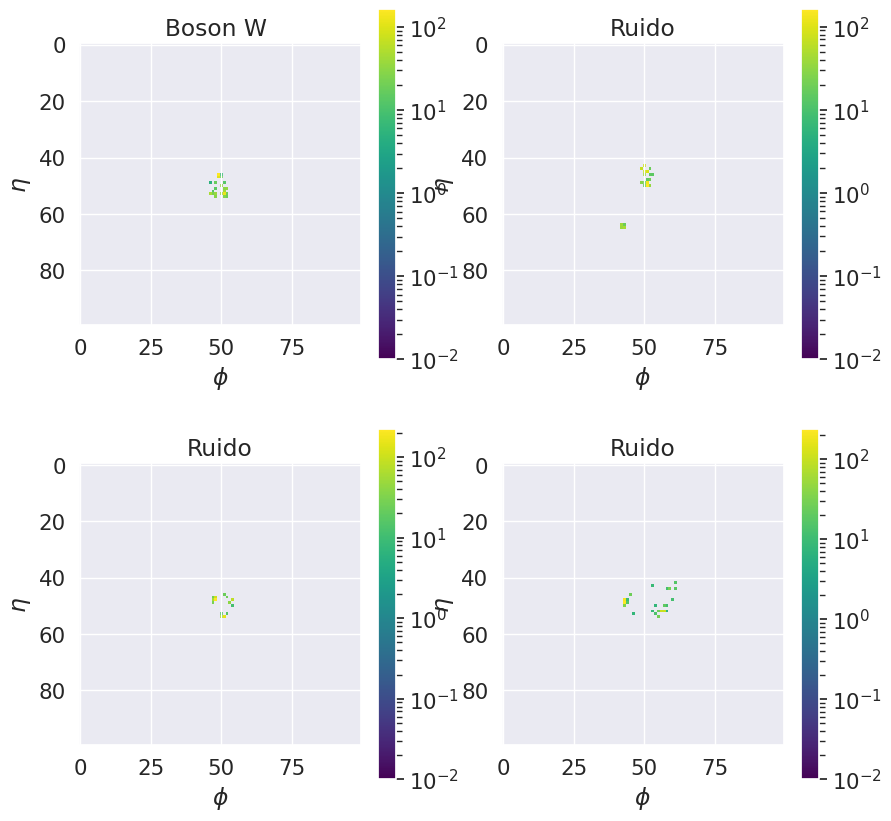

In [69]:
visualizar_dataset(dataset_treino)

# Modelo

In [42]:
from torch import nn

In [43]:
class MLPClassification(nn.Module):
  def __init__(self,entrada):
    super().__init__()


    self.layers = nn.Sequential(
        nn.Linear(entrada,100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.layers(x)

In [44]:
entrada =(100*100)

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
model = MLPClassification(entrada).to(device)

In [47]:
model

MLPClassification(
  (layers): Sequential(
    (0): Linear(in_features=10000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

# Otimizador

In [48]:
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
#lossfunction = nn.BCEWithLogitsLoss()
lossfunction = nn.BCELoss()

# Função Treino e Teste 

In [49]:
def train(modelo,dataloader,funcao_de_custo,otimizador):
  modelo.train() # esta praparado para ser treinado
  erro_acumulativo = 0.0
  for _, (data, target) in enumerate(dataloader):
    target, imgs =  target.float().to(device), data.to(device)

    pred = modelo(imgs)
    perda = funcao_de_custo(pred,target.unsqueeze(1).to(device))

    otimizador.zero_grad() # zero os gradientes acumulados
    perda.backward() #Calculo da gradiente
    otimizador.step() # anda para a direção de menos erro

    erro_acumulativo += perda.item()
  return erro_acumulativo/len(dataloader)


def test(modelo, dataloader, funcao_de_custo):
    modelo.eval()  
    total_acertos = 0
    total_exemplos = 0
    total_loss = 0.0

    with torch.no_grad():  
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.to(device)

            pred = modelo(imgs)
            loss = funcao_de_custo(pred, target.unsqueeze(1).to(device))

            # Arredonda as previsões para o valor mais próximo (0 ou 1)
            pred_labels = torch.round(pred)

            # Calcula o número de acertos
            total_acertos += (pred_labels == target.unsqueeze(1).to(device)).sum().item()
            total_exemplos += target.size(0)
            total_loss += loss.item()

    #accuracy = total_acertos / total_exemplos
    avg_loss = total_loss / len(dataloader)

    return  avg_loss

# Treinando

In [50]:
vezes_treinando = 300
train_losses = []
test_losses = []
for t in range(vezes_treinando):
  train_erro = train(model,train_dataloader,lossfunction,optimizer)
  train_losses.append(train_erro)
  if t %100 ==0:
    print(f"Epoca {t}; erro : {train_erro}")
  test_erro = test(model,test_dataloader,lossfunction)
  test_losses.append(test_erro)
print(f"erro : {test_erro}")

Epoca 0; erro : 0.5102273621516932
Epoca 100; erro : 0.3493632581593539
Epoca 200; erro : 0.32563060954047857
erro : 0.420824600757635


In [51]:
# Selecionando um exemplo específico do conjunto de dados de treinamento (por exemplo, o exemplo de índice 3)
example_index = 15
example_data, _ = dataset_teste[example_index]  # Ignorando o rótulo, pois não é necessário para a inferência

# Enviando o exemplo para o dispositivo (CPU ou GPU)
example_data = example_data.to(device)

# Passando o exemplo pelo modelo para obter a saída
output = model(example_data.unsqueeze(0))  # Usando unsqueeze para adicionar uma dimensão de lote (batch)

# A saída contém as previsões do modelo para o exemplo específico
print(output)


tensor([[0.7927]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [52]:
dataset_teste[15]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(0))

# Salvando modelo

In [53]:

caminho_arquivo = '../model/img/160_neuronios_unica.pth'

# Salvar o modelo
torch.save(model.state_dict(), caminho_arquivo)

# Metricas de avaliação

## Curva ROC

In [54]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(modelo, dataloader):
    modelo.eval()  # Define o modelo para o modo de avaliação
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Desliga o cálculo de gradientes para economizar memória e acelerar o processo
        for _, (data, target) in enumerate(dataloader):
            target, imgs = target.float().to(device), data.to(device)

            pred_probs = torch.sigmoid(modelo(imgs)).cpu().numpy()  # Probabilidades previstas pelo modelo
            all_probs.extend(pred_probs)
            all_labels.extend(target.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



### Teste

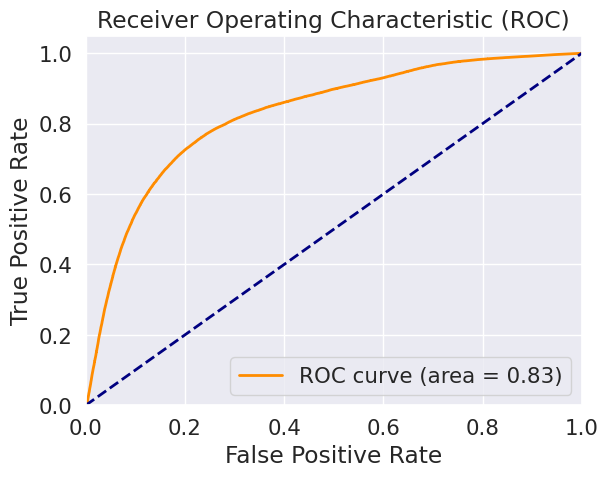

In [55]:
plot_roc_curve(model, test_dataloader)

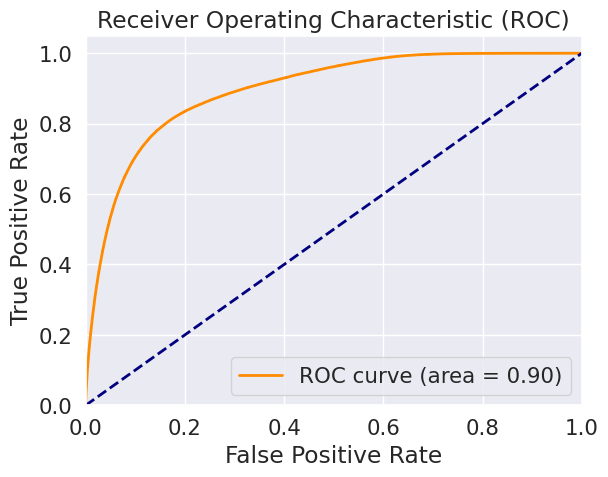

In [56]:
plot_roc_curve(model, train_dataloader)